In [ ]:
import random as rd

Variant = 21
rd.seed(Variant)


colors = ['COLOR_BLACK', 'COLOR_RED', 'COLOR_GREEN', 'СOLOR_YELLOW', 'COLOR_BLUE', 'COLOR_MAGENTA', 'COLOR_CYAN', 'COLOR_WHITE']
buttons = ['q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p', 'a', 's', 'd', 'f', 'g', 'h', 'j','k','l','z','x','c','v','b','n','m']
print("Алгоритм: " , rd.sample([1,2,3,4,5,6,7,8],1))
print("Цвета заполнения: " , rd.sample(colors,2))
print("Кнопки выхода, изменения скорости: " , rd.sample(buttons,2))

In [ ]:
;;example6.asm
format ELF64

	public _start

	extrn initscr
	extrn start_color
	extrn init_pair
	extrn getmaxx
	extrn getmaxy
	extrn raw
	extrn noecho
	extrn keypad
	extrn stdscr
	extrn move
	extrn getch
	extrn clear
	extrn addch
	extrn refresh
	extrn endwin
	extrn exit
	extrn color_pair
	extrn insch
	extrn cbreak
	extrn timeout
	extrn mydelay


	section '.bss' writable
	direction dq 0       ;; 0 = влево, 1 = вправо
	x dq 0
	y dq 0
	max_x dq 0          ;; Максимальная координата X
	max_y dq 0          ;; Максимальная координата Y
	speed dq 10000
	palette dq 1        ;; Текущий цвет (1 = CYAN, 2 = MAGENTA)
	fill_complete dq 0
	speed_level dq 1    ;; Уровень скорости (1-5)

	section '.data' writable
	fill_char db ' '

	section '.text' executable

_start:
	;; Инициализация
	call initscr

	;; Размеры экрана
	xor rdi, rdi
	mov rdi, [stdscr]
	call getmaxx
	mov [max_x], rax
	dec qword [max_x]
	call getmaxy
	mov [max_y], rax
	dec qword [max_y]

	call start_color

	;; CYAN
	mov rdx, 6
	mov rsi, 6
	mov rdi, 1
	call init_pair

	;; MAGENTA
	mov rdx, 5
	mov rsi, 5
	mov rdi, 2
	call init_pair

	call refresh
	call noecho
	call cbreak

	mov rax, [max_x]
	mov [x], rax
	mov qword [y], 0
	mov qword [direction], 0
	mov qword [palette], 0x100
	mov qword [fill_complete], 0
	mov qword [speed_level], 1
	mov qword [speed], 10000

mloop:
	mov rdi, [y]
	mov rsi, [x]
	call move

	mov rax, [fill_complete]
	cmp rax, 0
	je .cyan_fill
	jmp .magenta_fill

.cyan_fill:
	;; Заполняем CYAN
	call get_space
	or rax, 0x100
	mov [palette], rax
	jmp .print_char

.magenta_fill:
	;; Заполняем MAGENTA
	call get_space
	or rax, 0x200
	mov [palette], rax

.print_char:
	mov rdi, [palette]
	call addch

	call refresh

	mov rax, [direction]
	cmp rax, 0
	je .move_left
	jmp .move_right

.move_left:
	dec qword [x]
	cmp qword [x], 0
	jge .delay

	;; Достигли левого края - переходим на следующую строку
	mov qword [x], 0
	inc qword [y]
	mov qword [direction], 1
	jmp .check_bottom

.move_right:
	inc qword [x]
	mov rax, [x]
	cmp rax, [max_x]
	jle .delay

	;; Достигли правого края - переходим на следующую строку
	mov rax, [max_x]
	mov [x], rax
	inc qword [y]
	mov qword [direction], 0

.check_bottom:
	mov rax, [y]
	cmp rax, [max_y]
	jle .delay

	;; Достигли нижнего края
	mov rax, [fill_complete]
	cmp rax, 0
	jne .restart_cyan

	;; Переключаем на заполнение MAGENTA
	mov qword [fill_complete], 1
	jmp .restart_position

.restart_cyan:
	mov qword [fill_complete], 0

.restart_position:
	mov rax, [max_x]
	mov [x], rax
	mov qword [y], 0
	mov qword [direction], 0

.delay:
	mov rdi, [speed]
	call mydelay

	mov rdi, 1
	call timeout
	call getch

	cmp rax, 'f'        ;; Изменить скорость
	je .change_speed
	cmp rax, 'x'        ;; Выход
	je next
	jmp mloop

.change_speed:
	mov rax, [speed_level]
	inc rax
	cmp rax, 6
	jl .set_speed_level
	mov rax, 1
.set_speed_level:
	mov [speed_level], rax

	cmp rax, 1
	je .speed1
	cmp rax, 2
	je .speed2
	cmp rax, 3
	je .speed3
	cmp rax, 4
	je .speed4
	cmp rax, 5
	je .speed5

.speed1:
	mov qword [speed], 10000
	jmp mloop
.speed2:
	mov qword [speed], 5000
	jmp mloop
.speed3:
	mov qword [speed], 2000
	jmp mloop
.speed4:
	mov qword [speed], 1000
	jmp mloop
.speed5:
	mov qword [speed], 500
	jmp mloop

next:
	call endwin
	mov rdi, 0
	call exit

get_space:
	mov rax, ' '
	ret


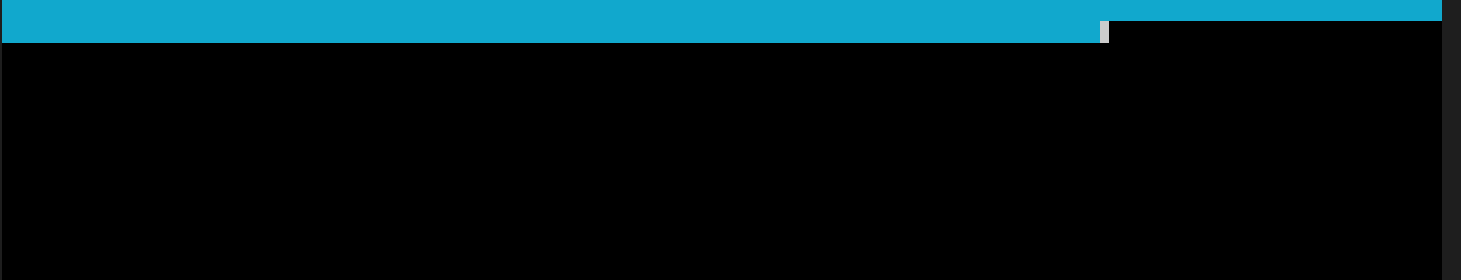